# Assignment 4

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [2]:
G1 = nx.read_gpickle("assets/A4_P1_G1")
G2 = nx.read_gpickle("assets/A4_P1_G2")
G3 = nx.read_gpickle("assets/A4_P1_G3")
G4 = nx.read_gpickle("assets/A4_P1_G4")
G5 = nx.read_gpickle("assets/A4_P1_G5")
P1_Graphs = [G1, G2, G3, G4, G5]

<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs using any methodology and determine which of the three algorithms generated each graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

In [24]:
def graph_identification():
    # YOUR CODE HERE
    import matplotlib.pyplot as plt
    
    global G1, G2, G3, G4, G5, P1_Graphs
    i = 0
    plt.subplots(2,3,figsize = (20,10))
    
    for graph in P1_Graphs:
        i += 1
        
        deg = [val for node, val in graph.degree()]
        hist_y = [deg.count(x)/nx.number_of_nodes(graph) for x in np.unique(deg)]
        hist_x = [x for x in np.unique(deg)]

        
        plt.subplot(2,3,i)
        plt.title('Degree Distributions on Log-log Scale for Graph G{}'.format(i))
        plt.xlabel('Degrees')
        plt.ylabel('Fraction of Nodes')
        plt.plot(hist_x, hist_y, 'o')
        plt.xscale('log')
        plt.yscale('log')
        # First Conclusion: [PA, SW, SW, PA, SW]
        
        if i in [2, 3, 5]:
            print('Avg Clustering of Graph G{}: {}'.format(i,nx.average_clustering(graph)))
            print('Avg Shortest Path of Graph G{}: {}'.format(i,nx.average_shortest_path_length(graph)))
        
        # Second Conclusion: [PA, SW_S, SW_S, PA, SW_H]
    
    return ['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']
    #raise NotImplementedError()

Avg Clustering of Graph G2: 0.49310000000000004
Avg Shortest Path of Graph G2: 43.80284684684685
Avg Clustering of Graph G3: 0.4897333333333334
Avg Shortest Path of Graph G3: 39.007695695695695
Avg Clustering of Graph G5: 0.36504285714285717
Avg Shortest Path of Graph G5: 8.532046046046046


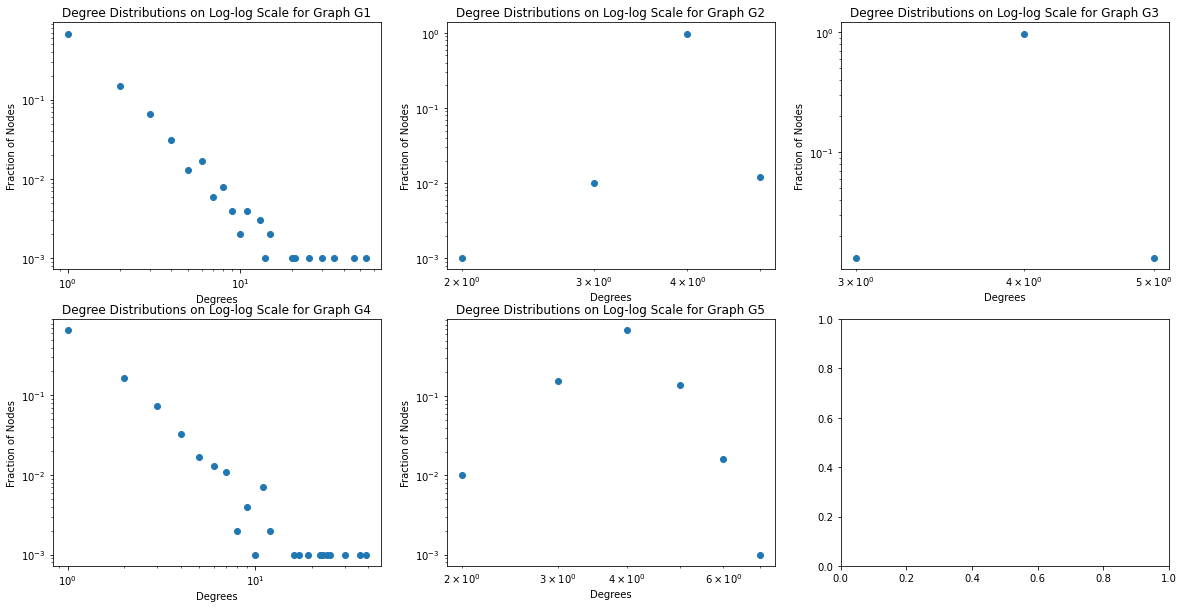

In [25]:
ans_one = graph_identification()
assert type(ans_one) == list, "You must return a list"


---

## Part 2 - Company Emails

For the second part of this assignment you will be working with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagmentSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagmentSalary` indicates whether that person is receiving a managment position salary.

In [5]:
G = pickle.load(open('assets/email_prediction_NEW.txt', 'rb'))

print(f"Graph with {len(nx.nodes(G))} nodes and {len(nx.edges(G))} edges")

Graph with 1005 nodes and 16706 edges


### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a managment position salary.

To accomplish this, you will need to create a matrix of node features of your choice using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a managment salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a managment position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.75 or higher will recieve full points.

Using your trained classifier, return a Pandas series of length 252 with the data being the probability of receiving managment salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [6]:
list(G.nodes(data=True))[:5] # print the first 5 nodes

[(0, {'Department': 1, 'ManagementSalary': 0.0}),
 (1, {'Department': 1, 'ManagementSalary': nan}),
 (581, {'Department': 3, 'ManagementSalary': 0.0}),
 (6, {'Department': 25, 'ManagementSalary': 1.0}),
 (65, {'Department': 4, 'ManagementSalary': nan})]

In [7]:
def salary_predictions():
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_auc_score
    
    # YOUR CODE HERE
    global G
    
    df = pd.DataFrame(G.nodes(data = True))
    df = pd.concat([df, df[1].apply(pd.Series)], axis = 1).drop(columns = 1).set_index(0).rename_axis('Node')

    df['deg'] = pd.Series(nx.degree_centrality(G))
    df['close'] = pd.Series(nx.closeness_centrality(G))
    df['between'] = pd.Series(nx.betweenness_centrality(G))
    df['pagerank'] = pd.Series(nx.pagerank(G))
    df[['hubs', 'auth']] = pd.DataFrame(nx.hits(G)).transpose()
    
    df_new = df[df['ManagementSalary'].isnull()]
    df_label = df[df['ManagementSalary'].notnull()]
    
    X_label = df_label.drop(columns = 'ManagementSalary')
    y_label = df_label['ManagementSalary']
    
    X_train, X_test, y_train, y_test = train_test_split(X_label, y_label, random_state = 0)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    clf = RandomForestClassifier(random_state = 0).fit(X_train_scaled, y_train)
    
    y_pred = clf.predict_proba(X_test_scaled)[:,1]
    #print('Test set ROC AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
    
    X_new = scaler.transform(df_new.drop(columns = 'ManagementSalary'))
    y_new = clf.predict_proba(X_new)[:,1]
    
    return pd.Series(y_new, index = df_new.index)
    #raise NotImplementedError()

Test set ROC AUC score: 0.8895297249334517


Node
1      0.03
65     0.91
18     0.23
215    0.81
283    1.00
       ... 
691    0.00
788    0.00
944    0.00
798    0.00
808    0.00
Length: 252, dtype: float64

In [8]:
ans_salary_preds = salary_predictions()
assert type(ans_salary_preds) == pd.core.series.Series, "You must return a Pandas series"
assert len(ans_salary_preds) == 252, "The series must be of length 252"


Test set ROC AUC score: 0.8895297249334517


### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [9]:
future_connections = pd.read_csv('assets/Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to:      
1. Create a matrix of features of your choice for the edges found in `future_connections` using Networkx     
2. Train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data     
3. Predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.75 or higher will recieve full points.

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [10]:
def new_connections_predictions():
    from sklearn.preprocessing import StandardScaler#, LabelEncoder
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_auc_score

    # YOUR CODE HERE
    global G, future_connections
    
    #future_connections[['A', 'B']] = [[tup[0], tup[1]] for tup in future_connections.index[:]]
    future_connections['common_neighbor'] = [len(list(nx.common_neighbors(G, tup[0], tup[1]))) for tup in future_connections.index]
    future_connections['res_all_index'] = [list(nx.resource_allocation_index(G, [pair]))[0][2] for pair in future_connections.index]
    future_connections['pref_attach'] = [list(nx.preferential_attachment(G, [pair]))[0][2] for pair in future_connections.index]
    future_connections = future_connections.rename_axis('Edge')
    
    df_new = future_connections[future_connections['Future Connection'].isnull()]
    df_label = future_connections[future_connections['Future Connection'].notnull()]
    
    X_label = df_label.drop(columns = 'Future Connection')
    y_label = df_label['Future Connection']
    
    X_train, X_test, y_train, y_test = train_test_split(X_label, y_label, random_state = 0)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    clf = RandomForestClassifier(random_state = 0).fit(X_train_scaled, y_train)
    
    y_pred = clf.predict_proba(X_test_scaled)[:,1]
    #print('Test set ROC AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
    
    X_new = scaler.transform(df_new.drop(columns = 'Future Connection'))
    y_new = clf.predict_proba(X_new)[:,1]
    
    return pd.Series(y_new, index = df_new.index)
    #raise NotImplementedError()

In [11]:
ans_prob_preds = new_connections_predictions()
assert type(ans_prob_preds) == pd.core.series.Series, "You must return a Pandas series"
assert len(ans_prob_preds) == 122112, "The series must be of length 122112"


Test set ROC AUC score: 0.8835216616837901
